In [15]:
import torch
import torch.nn as nn
from torchvision.models import resnet34, ResNet18_Weights, convnext_tiny, resnet50

model = resnet34(weights=None)
# model.features[0][0] = nn.Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
# model.classifier[2] = nn.Linear(768, 10, bias=True)

In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
import argparse
from model import CNN
import torch
import torch.nn.functional as F
from fmnist_dataset import load_fashion_mnist, FashionMNISTDataset
from torch.utils.data import DataLoader
import random
import numpy as np
from train import evaluate
import matplotlib.pyplot as plt
import pickle

class WhiteBoxAttacker():
    def __init__(self, model, epsilon, alpha) -> None:
        self.model = model
        self.epsilon = epsilon
        self.alpha = alpha

    def clip(self, x_updated, x):
        # element-wise clipping
        return torch.minimum( torch.minimum(x + self.epsilon, torch.full_like(x, 255)), torch.maximum(torch.full_like(x, 0), torch.maximum(x - self.epsilon, x_updated)))

    def attack(self, model, x, y_target):
        # reference: ADVERSARIAL EXAMPLES IN THE PHYSICAL WORLD, ICLR 2017
        # x: (batch_size, 1, 28, 28) FloatTensor
        # y_target : (batch_size) LongTensor
        model.eval()
        x_updated = x
        step_n = int(min(self.epsilon+4, self.epsilon*1.25))
        for step in range(step_n):
            x_updated.requires_grad_()
            logits = model(x_updated)
            loss = F.cross_entropy(logits, y_target)
            x_grad = torch.autograd.grad(loss, x_updated)[0].detach().clone()
            x_updated = self.clip(x_updated.detach() - self.alpha * torch.sign(x_grad), x)
            
        return x_updated.detach()

def generate_adversarial_examples(attacker, test_dataloader, example_n = 1000):
    model = attacker.model
    model.eval()

    x_correct = []
    y_correct = []

    for batch in test_dataloader:
        x, y = batch
        x, y = x.cuda(), y.cuda()
        logits = model(x)

        correct_index = (torch.argmax(logits, dim=1) == y)
        x_correct.append(x[correct_index])
        y_correct.append(y[correct_index])
    
    x_correct = torch.concatenate(x_correct, dim=0)
    y_correct = torch.concatenate(y_correct, dim=0)

    # sample 1000 examples
    random_sample = torch.LongTensor(np.random.choice(len(x_correct), example_n))
    x_correct = x_correct[random_sample]
    y_correct = y_correct[random_sample]

    correct_dataset = FashionMNISTDataset((x_correct, y_correct))
    correct_loader = DataLoader(correct_dataset, batch_size=50, shuffle=False)

    x_adv = []
    for batch in correct_loader:
        x, y = batch
        x, y = x.cuda(), y.cuda()
        y_target = (y + 1) % 10 
        adversarial_examples = attacker.attack(model, x, y_target)
        x_adv.append(adversarial_examples)
    
    # x_adv : (1000, embed_dim)
    x_adv = torch.concat(x_adv, dim=0)
    y_adv = (y_correct + 1) % 10

    return x_correct, y_correct, x_adv, y_adv

def success_rate_with_examples(model, x_adv, y_adv, example_n = 10):
    model.eval()
    dataloader = DataLoader(FashionMNISTDataset((x_adv, y_adv)), batch_size=50, shuffle=False)
    correct_n = 0
    total_n = 0
    offset = 0

    success_indicies = []

    for batch in dataloader:
        x, y = batch
        x, y = x.cuda(), y.cuda()
        logits = model(x)

        success_index = torch.nonzero((torch.argmax(logits, dim=1) == y), as_tuple=False)
        success_indicies.append(success_index + offset)
        offset += len(y)

        correct_n += (torch.argmax(logits, dim=1) == y).sum().item()
        total_n += len(y)
    
    attack_success_rate = correct_n / total_n
    success_indicies = torch.concat(success_indicies, dim=0).squeeze()
    random_sample = torch.LongTensor(np.random.choice(len(success_indicies), example_n))


    return attack_success_rate, success_indicies[random_sample] 

In [9]:
rand_seed = 42
torch.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)
random.seed(rand_seed)
np.random.seed(rand_seed)
device = "cuda"

model = CNN().cuda()
checkpoint_path = '../model/ep_16_devacc_90.59_.pt'
model.load_state_dict(torch.load(checkpoint_path))

attacker = WhiteBoxAttacker(model, epsilon=16, alpha=1.0)
_, _, test = load_fashion_mnist("../data", random=random)
test_dataloader = DataLoader(test, batch_size=64)

test_accuracy = evaluate(model, test_dataloader, 'cuda')
print("test_accuracy : {:.3f}".format(test_accuracy))

x_correct, y_correct, x_adv, y_adv = generate_adversarial_examples(attacker, test_dataloader, example_n = 1000)
attack_success_rate, success_indicies = success_rate_with_examples(model, x_adv, y_adv, example_n = 10)
print("attack_success_rate : {:.3f}".format(attack_success_rate))

test_accuracy : 90.190
attack_success_rate : 0.750


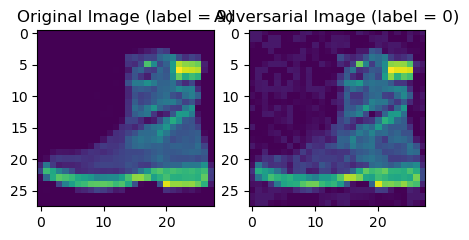

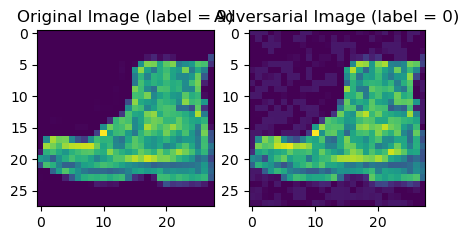

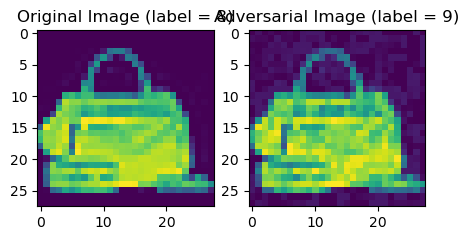

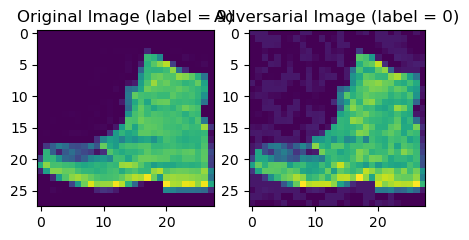

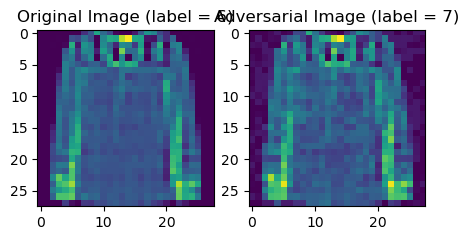

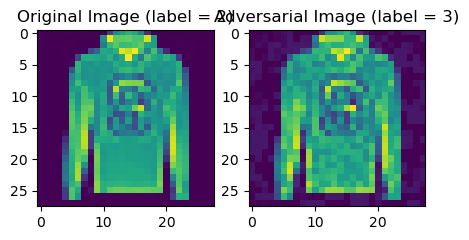

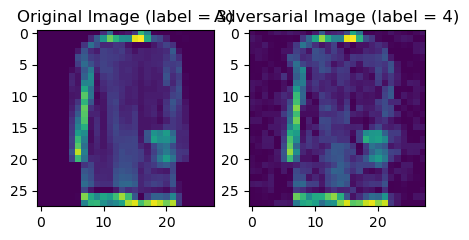

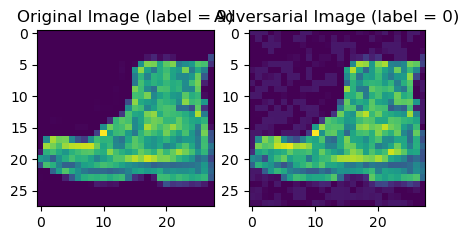

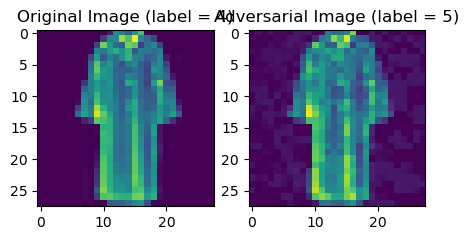

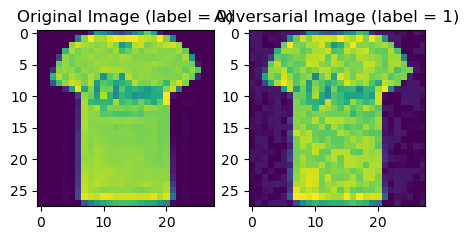

In [18]:
for i in range(len(success_indicies)):
    original_image = x_correct[success_indicies][i].reshape([28, 28]).cpu().numpy()
    original_label = y_correct[success_indicies][i].cpu().numpy()
    adversarial_image = x_adv[success_indicies][i].reshape([28, 28]).cpu().numpy()
    adversarial_label = y_adv[success_indicies][i].cpu().numpy()
    fig, axs = plt.subplots(1,2, figsize=(10, 20))
    axs[0].imshow(original_image)
    axs[0].set_title("Original Image (label = {})".format(original_label))
    axs[1].imshow(adversarial_image)
    axs[1].set_title("Adversarial Image (label = {})".format(adversarial_label))
    fig.savefig()


In [19]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [25]:
m = MultivariateNormal(torch.zeros(2), torch.eye(2))
m.sample([10]).shape

torch.Size([10, 2])

In [29]:
torch.rand(1)[0]

tensor(0.1611)

In [12]:
import pickle
with open('../attack_data/correct_1k.pkl', 'rb') as f:
    x, y = pickle.load(f)



(1000, 784)

In [6]:
a, b = x[0], x[1]

In [10]:
import numpy as np

np.array(b).shape

(1000,)